# Alternative Tracing Methods

![AWTT](../../images/alternative_ways_to_trace_0.png)

So far in this module, we've taken a look at the traceable decorator, and how we can use it to set up tracing.

In this lesson, we're going to look at alternative ways in which we can set up tracing, and when you should think about using these different approaches.

## LangChain and LangGraph

If we are using LangChain or LangGraph, all we need to do to set up tracing is to set a few environment variables

![AWTT](../../images/alternative_ways_to_trace_1.png)

In [14]:
# You can set them inline
import os
os.environ["USER_AGENT"] = "LangSmithRAG/1.0 (Python; Ollama)"
os.environ["LANGCHAIN_API_KEY"] = ""
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langsmith-academy"  # If you don't set this, traces will go to the Default project

In [1]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

Don't worry too much about our graph implementation here, you can learn more about LangGraph through our LangGraph Academy course!

USER_AGENT environment variable not set, consider setting it to identify your requests.


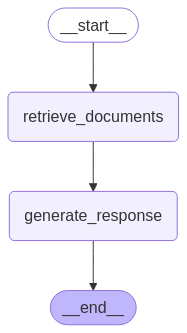

In [2]:
import nest_asyncio
import operator
from langchain.schema import Document
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict, Annotated
from utils import get_vector_db_retriever, RAG_PROMPT

nest_asyncio.apply()

retriever = get_vector_db_retriever()
llm = ChatOllama(model="llama3.2", temperature=0)

# Define Graph state
class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]

# Define Nodes
def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    question = state["question"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question}")
    return {"documents": documents}

def generate_response(state: GraphState):
    question = state["question"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, conversation=messages, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "messages": [HumanMessage(question), generation]}

# Define Graph
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))

We're setting up a simple graph in LangGraph. If you want to learn more about LangGraph, I would highly recommend taking a look at our LangGraph Academy course.

You can also pass in metadata or other fields through an optional config

In [3]:
question = "How do I set up tracing if I'm using LangChain?"
simple_rag_graph.invoke({"question": question}, config={"metadata": {"foo": "bar"}})

{'question': "How do I set up tracing if I'm using LangChain?",
 'messages': [HumanMessage(content="How do I set up tracing if I'm using LangChain?", additional_kwargs={}, response_metadata={}),
  AIMessage(content="To set up tracing with LangChain, you need to set the LANGCHAIN_TRACING_V2 environment variable to 'true' and the LANGCHAIN_API_KEY environment variable to your API key. Additionally, you can configure other settings such as LANGCHAIN_CALLBACKS_BACKGROUND to reduce latency.", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-03-08T20:19:04.337052892Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1984111903, 'load_duration': 1348127955, 'prompt_eval_count': 989, 'prompt_eval_duration': 246000000, 'eval_count': 57, 'eval_duration': 388000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-522cc4c4-20c9-4915-acb2-30824dea866d-0', usage_metadata={'input_tokens': 989, 'output_tokens': 57, 'total

##### Let's take a look in LangSmith!

## Tracing Context Manager

In Python, you can use the trace context manager to log traces to LangSmith. This is useful in situations where:

You want to log traces for a specific block of code.
You want control over the inputs, outputs, and other attributes of the trace.
It is not feasible to use a decorator or wrapper.
Any or all of the above.
The context manager integrates seamlessly with the traceable decorator and wrap_openai wrapper, so you can use them together in the same application.

You still need to set your `LANGCHAIN_API_KEY` and `LANGCHAIN_TRACING_V2`

![AWTT](../../images/alternative_ways_to_trace_2.png)

In [ ]:
from langsmith import traceable, trace
from openai import OpenAI
from typing import List
import nest_asyncio
import requests
from utils import get_vector_db_retriever

MODEL_PROVIDER = "ollama"
MODEL_NAME = "llama3.2"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI(
    base_url="http://localhost:11434/v1",
    api_key="ollama",
)


OLLAMA_API_URL = "http://localhost:11434/api/chat"
nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable
def retrieve_documents(question: str):
    documents = retriever.invoke(question)
    return documents

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    with trace(
        name="Generate Response",
        run_type="chain",
        inputs={"question": question, "formatted_docs": formatted_docs},
        metadata={"foo": "bar"},
    ) as ls_trace:
        messages = [
            {"role": "system", "content": RAG_SYSTEM_PROMPT},
            {"role": "user", "content": f"Context: {formatted_docs} \n\n Question: {question}"}
        ]
        response = call_openai(messages)
        ls_trace.end(outputs={"output": response})
        return response

"""
call_openai
- Returns the chat completion output using OpenAI client or Ollama native API
"""
@traceable
def call_openai(
    messages: List[dict],
    model: str = MODEL_NAME,
    temperature: float = 0.0
) -> str:
    try:

        response = openai_client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=temperature,
        )
        return response.choices[0].message.content
    except Exception as e:

        payload = {
            "model": model,
            "messages": messages,
            "temperature": temperature,
            "stream": False
        }
        response = requests.post(OLLAMA_API_URL, json=payload)
        response.raise_for_status()
        return response.json()["message"]["content"]

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response

In [5]:
question = "How do I trace with tracing context?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To use the tracing context, you should import the `tracing_context` from the `langsmith.run_helpers` module and then wrap your code within it. The example provided shows how to use this context manager in a server application. You can also use the `traceable` decorator on functions or classes to enable tracing automatically.


## wrap_openai

The wrap_openai/wrapOpenAI methods in Python/TypeScript allow you to wrap your OpenAI client in order to automatically log traces -- no decorator or function wrapping required! The wrapper works seamlessly with the @traceable decorator or traceable function and you can use both in the same application.

You still need to set your `LANGCHAIN_API_KEY` and `LANGCHAIN_TRACING_V2`

![AWTT](../../images/alternative_ways_to_trace_3.png)

In [ ]:
# TODO: Import wrap_openai
from langsmith.wrappers import wrap_openai
from langsmith import traceable
import openai
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "ollama"
MODEL_NAME = "llama3.2:latest"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

# TODO: Wrap the OpenAI Client
openai_client = wrap_openai(
    openai.Client(
        base_url="http://localhost:11434/v1",
        api_key="ollama"
    )
)
nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    # TODO: We don't need to use @traceable on a nested function call anymore,
    # wrap_openai takes care of this for us
    return call_openai(messages)

@traceable
def call_openai(
    messages: List[dict],
) -> str:
    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

@traceable(run_type="chain")
def langsmith_rag_with_wrap_openai(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content

In [7]:
question = "How do I trace with wrap_openai?"
ai_answer = langsmith_rag_with_wrap_openai(question)
print(ai_answer)

To use the `wrap_openai` method in Python or TypeScript, you need to import it from "langsmith/traceable" and then call it with the OpenAI client instance, like so:

```python
import { wrap_openai } from 'langsmith/traceable';
const openai = new OpenAI(); // Create an instance of the OpenAI client
const wrappedClient = wrap_openai(openai); // Wrap the OpenAI client for tracing
```

In TypeScript, you would use `wrapOpenAI` instead:

```typescript
import { wrapOpenAI } from 'langsmith/traceable';
const openai = new OpenAI(); // Create an instance of the OpenAI client
const wrappedClient = wrapOpenAI(openai); // Wrap the OpenAI client for tracing
```

After wrapping, you can use your wrapped client instance as before.


The wrapped OpenAI client accepts all the same langsmith_extra parameters as @traceable decorated functions

In [8]:
messages = [
    {
        "role": "user",
        "content": "What color is the sky?"
    }
]

openai_client.chat.completions.create(
    model=MODEL_NAME,
    messages=messages,
    langsmith_extra={"metadata": {"foo": "bar"}},
)

ChatCompletion(id='chatcmpl-312', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The color of the sky can vary depending on the time of day, atmospheric conditions, and other factors. Here are some common colors of the sky:\n\n1. **Blue**: During a clear day, the sky typically appears blue due to a phenomenon called Rayleigh scattering, where shorter wavelengths of light (like blue and violet) are scattered more than longer wavelengths (like red and orange).\n2. **Sunrise and sunset**: During these times, the sky can take on hues of warm colors like orange, pink, red, and purple, depending on the amount of dust and water vapor in the atmosphere.\n3. **Cloudy skies**: On overcast days, the sky can appear gray or white due to the scattering of light by cloud particles.\n4. **Twilight**: During twilight hours (just before sunrise or after sunset), the sky can take on a range of colors including pink, orange, purple, and blue.\n5. **At 

## [Advanced] RunTree

Another, more explicit way to log traces to LangSmith is via the RunTree API. This API allows you more control over your tracing - you can manually create runs and children runs to assemble your trace. You still need to set your `LANGCHAIN_API_KEY`, but `LANGCHAIN_TRACING_V2` is not necessary for this method.

![AWTT](../../images/alternative_ways_to_trace_4.png)

In [9]:
import os
os.environ["LANGCHAIN_API_KEY"] = ""
os.environ["LANGCHAIN_PROJECT"] = "langsmith-academy"
os.environ["USER_AGENT"] = "LangSmithRAG/1.0 (Python; Ollama)"

In [10]:
from dotenv import load_dotenv
# I have my env variables defined in a .env file
load_dotenv(dotenv_path="../../.env", override=True)

True

Let's go ahead and set `LANGCHAIN_TRACING_V2` to false, as we are using RunTree to manually create runs in this case.

In [11]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"

from langsmith import utils
utils.tracing_is_enabled() # This should return false

True

We have rewritten our RAG application, except this time we pass a RunTree argument through our function calls, and create child runs at each layer. This gives our RunTree the same hierarchy that we were automatically able to establish with @traceable

In [ ]:
from langsmith import RunTree
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

openai_client = OpenAI(
    base_url='http://localhost:11434/v1',
    api_key='ollama',  # requis mais non utilisé par Ollama
)
nest_asyncio.apply()
retriever = get_vector_db_retriever()

def retrieve_documents(parent_run: RunTree, question: str):
    # Create a child run
    child_run = parent_run.create_child(
        name="Retrieve Documents",
        run_type="retriever",
        inputs={"question": question},
    )
    documents = retriever.invoke(question)
    # Post the output of our child run
    child_run.end(outputs={"documents": documents})
    child_run.post()
    return documents

def generate_response(parent_run: RunTree, question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the latest question in the conversation. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    """
    # Create a child run
    child_run = parent_run.create_child(
        name="Generate Response",
        run_type="chain",
        inputs={"question": question, "documents": documents},
    )
    messages = [
        {
            "role": "system",
            "content": rag_system_prompt
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    openai_response = call_openai(child_run, messages)
    # Post the output of our child run
    child_run.end(outputs={"openai_response": openai_response})
    child_run.post()
    return openai_response

def call_openai(
    parent_run: RunTree, messages: List[dict], model: str = "llama3.2", temperature: float = 0.0
) -> str:
    # Create a child run
    child_run = parent_run.create_child(
        name="OpenAI Call",
        run_type="llm",
        inputs={"messages": messages},
    )
    openai_response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    # Post the output of our child run
    child_run.end(outputs={"openai_response": openai_response})
    child_run.post()
    return openai_response.choices[0].message.content  # Ajouté pour retourner directement le contenu

def langsmith_rag(question: str):
    # Create a root RunTree
    root_run_tree = RunTree(
        name="Chat Pipeline",
        run_type="chain",
        inputs={"question": question}
    )

    # Pass our RunTree into the nested function calls
    documents = retrieve_documents(root_run_tree, question)
    response = generate_response(root_run_tree, question, documents)
    output = response  # Modifié car call_openai retourne déjà le contenu

    # Post our final output
    root_run_tree.end(outputs={"generation": output})
    root_run_tree.post()
    return output

In [13]:
question = "How can I trace with RunTree?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To use the RunTree API, you need to create a RunTree object from the request headers and then pass it to the `withRunTree` function along with your traced function. The `withRunTree` function will execute your traced function within the context of the RunTree, allowing you to access tracing metadata such as the current run (span) and its children.
